**NOTE**: If the jupyter kernel does not start you might have to uninstall and reinstall the `typing_extensions` package with pip.

In [1]:
from IPython.display import Image
from itertools import product
import numpy as np
from stable_baselines3.ppo import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import torch
from torch.functional import F

from stackelberg_mbrl.envs.learned_env import DiscreteLearnedEnv
from stackelberg_mbrl.envs.simple_mdp import simple_mdp_2
from stackelberg_mbrl.nn.model.world_models import StaticDiscreteModel
from stackelberg_mbrl.util.tensor_util import one_hot

In [18]:
# Load fully pre-trained model
policy = PPO.load("checkpoints/pretrained_policy2.zip")

In [19]:
max_episode_steps = 50
true_env = simple_mdp_2(max_episode_steps)

# Sample true initial state distribution
init_state_probs = []
for i in range(100):
    init_state,_ = true_env.reset()
    init_state_probs.append(one_hot(init_state, true_env.observation_dim).numpy())
init_state_probs = np.mean(init_state_probs, axis=0)

In [20]:
# Generate evaluation models
eval_random_models = [
        DiscreteLearnedEnv(StaticDiscreteModel(true_env, init_state_probs, true_env.is_done, true_env.reward), 
                           true_env.action_space, true_env.observation_space, max_episode_steps)
        for _ in range(10)]

In [5]:
for i, eval_model in enumerate(eval_random_models):
    eval_model.env_model.draw_mdp(f"mdps/eval{i}.png")

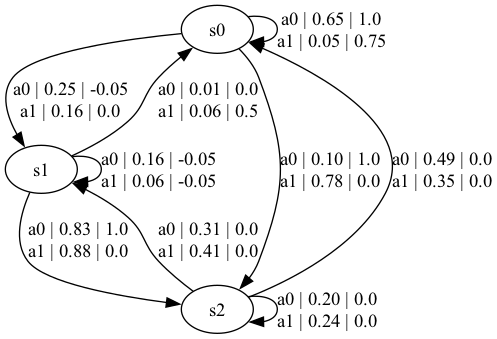

In [6]:
# Display an eval model env
Image(filename='mdps/eval0.png')

In [21]:
observation_space = F.one_hot(torch.arange(true_env.observation_dim, requires_grad=False), num_classes=true_env.observation_dim).float()
action_space = F.one_hot(torch.arange(true_env.action_dim, requires_grad=False), num_classes=true_env.action_dim).float()
dynamics_queries = list(product(observation_space, action_space))

In [22]:
# check how good we are currently doing on the best possible environment (the true one)
eval_true_env = DiscreteLearnedEnv(StaticDiscreteModel(true_env, init_state_probs, true_env.is_done, true_env.reward), 
                        true_env.action_space, true_env.observation_space, max_episode_steps=max_episode_steps)
eval_true_env.env_model.set_transition_probs(torch.from_numpy(np.array(true_env.transitions)).float())
true_env_queries = eval_true_env.env_model.query(dynamics_queries).detach()

In [23]:
# Train PPO agents on each eval environment to see how much reward can be obtained
env_specific_models = []
for eval_model in eval_random_models:
    model = PPO("MlpPolicy", eval_model, n_steps=10)
    model.learn(total_timesteps=10000)
    env_specific_models.append(model)

In [24]:
true_env_model = PPO("MlpPolicy", true_env)
true_env_model.learn(total_timesteps=10000)

In [25]:
print(evaluate_policy(true_env_model, true_env, n_eval_episodes=100))
policy.policy.features_extractor.set_context(true_env_queries)
print(evaluate_policy(policy.policy, true_env, n_eval_episodes=100))

(36.593999999389055, 0.9286893999645222)
(36.545999999344346, 1.1934755978456877)


In [26]:
for i, (eval_model, env_specific_model) in enumerate(zip(eval_random_models, env_specific_models)):
    print(f"Evalutaing random model {i}")
    print("Env specific baseline: ", evaluate_policy(env_specific_model, eval_model, n_eval_episodes=100))
    policy.policy.features_extractor.set_context(eval_model.env_model.query(dynamics_queries).detach())
    print("Our contexualized policy: ", evaluate_policy(policy.policy, eval_model, n_eval_episodes=100))

Evalutaing random model 0
Env specific baseline:  (0.9874999995157122, 0.15303185973657937)
Our contexualized policy:  (0.9809999995678663, 0.09559811728419344)
Evalutaing random model 1
Env specific baseline:  (1.2834999999776482, 1.048309472429352)
Our contexualized policy:  (1.0019999989122153, 1.9809583535176059)
Evalutaing random model 2
Env specific baseline:  (15.801999983042478, 14.400281092216641)
Our contexualized policy:  (1.1789999995753169, 0.9845603079358785)
Evalutaing random model 3
Env specific baseline:  (1.1494999993219972, 0.5102692917483816)
Our contexualized policy:  (1.7714999869465828, 2.4831557978060124)
Evalutaing random model 4
Env specific baseline:  (1.6804999999329449, 2.0500353045543274)
Our contexualized policy:  (1.9574999999254943, 2.2842654727225167)
Evalutaing random model 5
Env specific baseline:  (0.9649999994784594, 0.056347139187561006)
Our contexualized policy:  (0.9754999996349215, 0.040308188354493485)
Evalutaing random model 6
Env specific ba